In [1]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
MAIN_PATH = "../data"

/home/fcinus/miniconda3/envs/csimpact/lib/python3.11/site-packages/lifelines/datasets/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [ ]:
def run_survival_analysis(df_papers, color, linestyle, label, ax=None):
    # Fitting the model
    kmf = KaplanMeierFitter()
    kmf.fit(df_papers['duration'].dropna(), event_observed=df_papers.dropna(subset='duration')['is_observed'])

    # Drawing the survival plot
    if ax is None:
        fig, ax = plt.subplots()
    
    (1 - kmf.survival_function_).plot(ax=ax, label=label, color=color, linestyle=linestyle)
    return kmf

def draw_plot(df_papers, delta='first'):
    sns.lineplot(
        x='year_pub',
        y=f'delta_{delta}_citation',
        data=df_papers.query('year_pub >= 2015'),
        estimator='median',
    )
    if delta == 'first':
        plt.title('The median time lag of the first citation by an AI paper\nfor AI papers published in year X')
    elif delta == 'peak':
        plt.title('The median time lag of the peak citations\nfor AI papers published in year X')
    plt.xlabel('Publication year')
    plt.ylabel('Time difference (year)')
    sns.despine()

In [ ]:
corpus = pl.read_parquet(f'{MAIN_PATH}/corpus-240306.parquet')
df = (
    corpus
    .filter(~pl.col('title').str.contains('(survey|benchmark|review|tutorial)'))
    .to_pandas()
)
df['topic'] = df['venue_area']

In [4]:
df['is_innovation_success'] = df['year_min_innovation'].notnull()
df['is_development_success'] = df['year_min_development'].notnull()

In [5]:
plt.rcParams['font.size'] = 12

In [6]:
venue_areas = ['ai', 'information', 'mining', 'hci', 'linguistic', 'vision', 'impactful', 'average']
venue_map = {
    'impactful': 'Top General Science',
    'average': 'Computer Science',
    'ai': 'AI',
    'hci': 'HCI',
    'linguistic': 'NLP',
    'information': 'Database',
    'mining': 'Data Mining',
    'vision': 'Computer Vision',
}

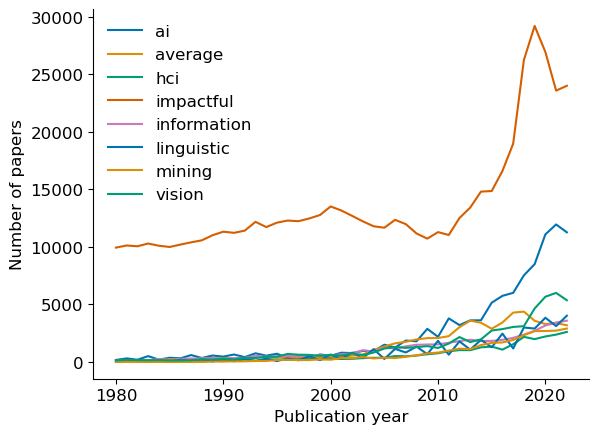

In [7]:
with sns.color_palette("colorblind", 5):
    fig, ax = plt.subplots()

    df.pivot_table(
        index='year',
        columns='topic',
        values='corpusid',
        aggfunc='count',
        fill_value=0
    ).plot.line(ax=ax)


    plt.xlabel('Publication year')
    plt.ylabel('Number of papers')
    plt.legend(frameon=False)
    sns.despine()

## Figure 2

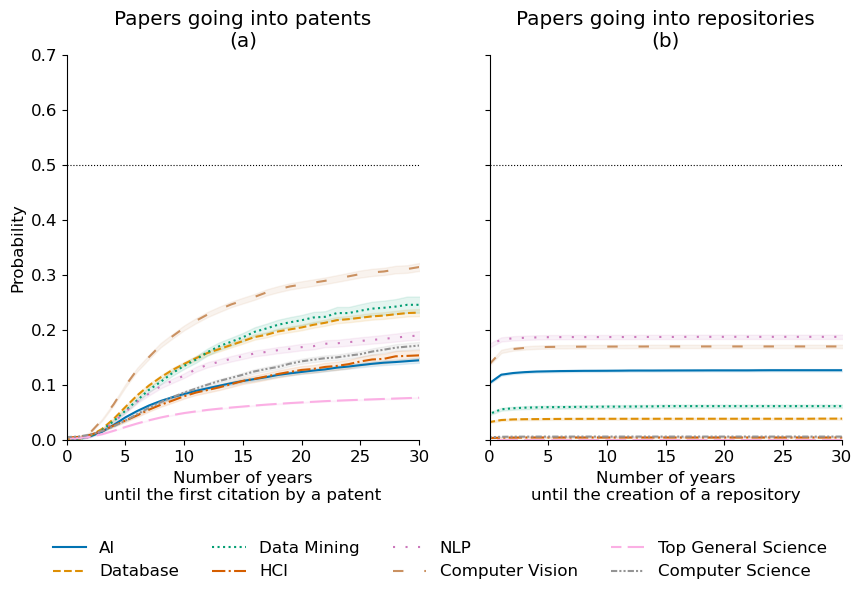

In [8]:
palette = sns.color_palette("colorblind", 8)
linestyles = ['-', '--', ':', '-.', (0, (1, 5)), (0, (5, 10)), (5, (10, 3)), (0, (3, 1, 1, 1, 1, 1))]
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)

for ax, metric in zip(axes.flatten(), ['innovation', 'development']):
    df['is_observed'] = df[f'year_min_{metric}'].notna()
    df['duration'] = df[f'year_min_{metric}'].astype(float).fillna(2023) - df['year'].astype(float)

    for i, topic in enumerate(venue_areas):
        group = df.query('venue_area == @topic')
        kmf = run_survival_analysis(group, color=palette[i], linestyle=linestyles[i], label='topic', ax=ax)
        ci = kmf.confidence_interval_survival_function_.loc[0:]
        ax.fill_between(ci.index, *(1 - ci.values.T), color=palette[i], alpha=.1, label='_nolegend_')

    ax.axhline(0.5, linestyle=':', c='k', linewidth=.8)

    ax.set_xlim(0, 30)
    ax.set_ylim(0, 0.7)

axes[0].set_xlabel('Number of years\nuntil the first citation by a patent')
axes[1].set_xlabel('Number of years\nuntil the creation of a repository')
axes[0].set_ylabel('Probability')
axes[0].legend([], frameon=False)
axes[1].legend([venue_map[topic] for topic in venue_areas], loc=4, bbox_to_anchor=(1, -0.4), ncol=4, frameon=False)

axes[0].set_title('Papers going into patents\n(a)')
axes[1].set_title('Papers going into repositories\n(b)')
# plt.tight_layout()
sns.despine()
plt.savefig('../figures/survival.pdf', bbox_inches='tight')